In [1]:
import os
import numpy
import pandas
import seaborn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

seaborn.set_style('whitegrid')
seaborn.set_palette('colorblind')
seaborn.set_context('paper')

In [2]:
DATA_DIRECTORY = './petfinder_dataset/'
TARGET_COL = 'AdoptionSpeed'

In [3]:
def load_dataset(dataset_dir):

    # Read train dataset (and maybe dev, if you need to...)
    dataset, dev_dataset = train_test_split(
        pandas.read_csv(os.path.join(dataset_dir, 'train.csv')), test_size=0.2)
         
    test_dataset = pandas.read_csv(os.path.join(dataset_dir, 'test.csv'))
    
    print('Training samples {}, test_samples {}'.format(
        dataset.shape[0], test_dataset.shape[0]))
    
    return dataset, dev_dataset, test_dataset

In [4]:
dataset, dev_dataset, test_dataset = load_dataset(DATA_DIRECTORY)
nlabels = dataset[TARGET_COL].unique().shape[0]
dataset.describe()

Training samples 8465, test_samples 4411


,Type,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,AdoptionSpeed,PID
count,8465.000000,8465.000000,8465.000000,8465.000000,8465.000000,8465.000000,8465.000000,8465.000000,8465.000000,8465.000000,8465.000000,8465.000000,8465.000000,8465.000000,8465.000000,8465.000000,8465.000000,8465.000000,8465.000000
mean,1.453160,10.393621,265.767750,74.309155,1.779917,2.235558,3.228825,1.852688,1.861784,1.466037,1.729711,1.567986,1.909864,1.036976,1.585470,21.387714,41345.893089,2.522032,7501.166450
std,0.497831,17.874214,59.574473,123.397664,0.681322,1.749976,2.745287,2.972092,0.545895,0.596984,0.667888,0.700318,0.559991,0.199665,1.475878,80.814709,32.356357,1.173719,4305.337337
min,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,41324.000000,0.000000,0.000000
25%,1.000000,2.000000,265.000000,0.000000,1.000000,1.000000,0.000000,0.000000,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,0.000000,41326.000000,2.000000,3777.000000
50%,1.000000,3.000000,266.000000,0.000000,2.000000,2.000000,2.000000,0.000000,2.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,0.000000,41326.000000,2.000000,7530.000000
75%,2.000000,12.000000,307.000000,187.000000,2.000000,3.000000,6.000000,5.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000,0.000000,41401.000000,4.000000,11210.000000
max,2.000000,212.000000,307.000000,307.000000,3.000000,7.000000,7.000000,7.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,20.000000,3000.000000,41401.000000,4.000000,14992.000000


<Figure size 720x432 with 0 Axes>

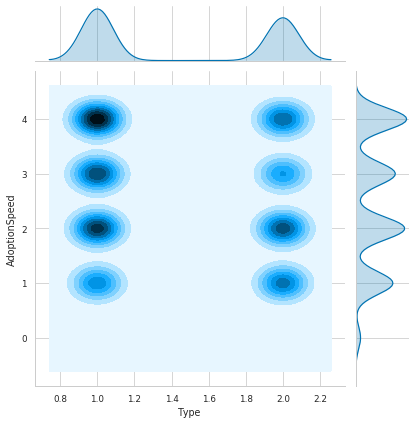

In [5]:
plt.figure(figsize=(10,6))
seaborn.jointplot(data=dataset, x='Type', y='AdoptionSpeed', kind='kde')

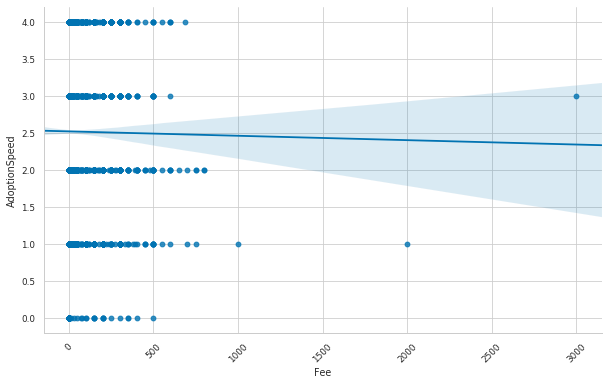

In [6]:
plt.figure(figsize=(10,6))
 
seaborn.regplot(data=dataset, x= 'Fee' , y='AdoptionSpeed')
plt.xticks(rotation=45)
seaborn.despine()

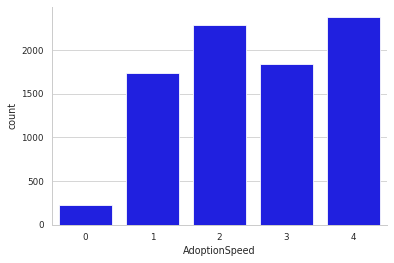

In [7]:
seaborn.countplot(dataset.AdoptionSpeed, color='blue')
seaborn.despine()

In [8]:
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf

from tensorflow.keras import layers, models

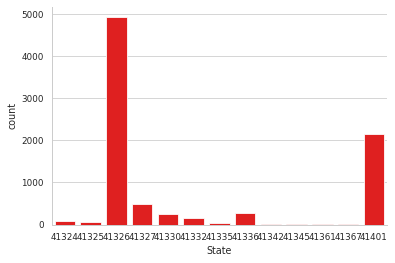

In [9]:
seaborn.countplot(dataset.State, color='red')
seaborn.despine()

In [10]:
one_hot_columns = {
    one_hot_col: dataset[one_hot_col].max()
    for one_hot_col in ['Gender', 'Color1' ,'Type' ,'Color2', 'Color3', 'MaturitySize','Vaccinated' ,'Dewormed', 'Sterilized','Health']
}
#crea un diccionario con nombre de col y valor maximo de cada categoria ej: {'Gender': 3, 'Color1': 7}

embedded_columns = {
    embedded_col: dataset[embedded_col].max() + 1
    for embedded_col in ['Breed1','Breed2']
} 

numeric_columns = ['Age', 'Fee']

In [11]:
def process_features(df, test=False):
    direct_features = []

    # Create one hot encodings
    for one_hot_col, max_value in one_hot_columns.items():
        direct_features.append(tf.keras.utils.to_categorical(df[one_hot_col] - 1, max_value))
           
    # Concatenate all features that don't need further embedding into a single matrix.
    features = {'direct_features': numpy.hstack(direct_features)}

    # Create embedding columns - nothing to do here. We will use the zero embedding for OOV
    for embedded_col in embedded_columns.keys():
        features[embedded_col] = df[embedded_col].values

    # Create and append numeric columns   
    #normalizado Agregado por JPA
    for n_col in numeric_columns:
        features[n_col] = df[n_col].values - df[n_col].mean() / df[n_col].std()
        
    if not test:
        nlabels = df[TARGET_COL].unique().shape[0]
        # Convert labels to one-hot encodings
        targets = tf.keras.utils.to_categorical(df[TARGET_COL], nlabels)
    else:
        targets = None
        
    
    return features, targets

In [12]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 50

X_train, y_train = process_features(dataset)
direct_features_input_shape = (X_train['direct_features'].shape[1],)

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(BATCH_SIZE).shuffle(buffer_size=SHUFFLE_BUFFER_SIZE)

X_dev, y_dev = process_features(dev_dataset)

test_ds = tf.data.Dataset.from_tensor_slices((X_dev, y_dev)).batch(BATCH_SIZE)

#Kaggle salida para la competencia.
X_kagg, y_kagg = process_features(test_dataset, test=True)
kagg_ds = tf.data.Dataset.from_tensor_slices(X_kagg).batch(BATCH_SIZE)

In [27]:
tf.keras.backend.clear_session()

In [28]:
HIDDEN_LAYER_SIZE = 100
DROPOUT_RATE = 0.25

# Add one input and one embedding for each embedded column
embedding_layers = []
inputs = []

for embedded_col, max_value in embedded_columns.items():
    input_layer = layers.Input(shape=(1,), name=embedded_col)
    inputs.append(input_layer)
    # Define the embedding layer
    embedding_size = int(max_value / 4)
    embedding_layers.append(
        tf.squeeze(layers.Embedding(input_dim=max_value, output_dim=embedding_size)(input_layer), axis=-2))
    
    print('Adding embedding of size {} for layer {}'.format(embedding_size, embedded_col))

# Add the direct features already calculated
direct_features_input = layers.Input(shape=direct_features_input_shape, name='direct_features')
inputs.append(direct_features_input)
            
# Concatenate everything together
features = layers.concatenate(embedding_layers + [direct_features_input])

dense1 = layers.Dense(HIDDEN_LAYER_SIZE, activation='relu')(features)

drop1 = layers.Dropout(DROPOUT_RATE)(dense1)

dense2 = layers.Dense(HIDDEN_LAYER_SIZE / 2, activation='relu')(drop1)

drop2 = layers.Dropout(DROPOUT_RATE)(dense2)

dense3 = layers.Dense(HIDDEN_LAYER_SIZE / 4, activation='relu')(drop2)

output_layer = layers.Dense(nlabels, activation='softmax')(dense3)

model = models.Model(inputs=inputs, outputs=output_layer)

 
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Adding embedding of size 77 for layer Breed1
Adding embedding of size 77 for layer Breed2
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Breed1 (InputLayer)             [(None, 1)]          0                                            
__________________________________________________________________________________________________
Breed2 (InputLayer)             [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 77)        23716       Breed1[0][0]                     
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 77)        23716       Breed2[0][0]                     
____

In [29]:
import mlflow
mlflow.set_experiment('tp1_20191018_03')

epochs = 10

with mlflow.start_run(nested=True):
    # Log model hiperparameters first        
    mlflow.log_param('epochs', epochs)
    mlflow.log_param('batch_size',BATCH_SIZE)
    mlflow.log_param('hidden_layer_size', HIDDEN_LAYER_SIZE)
    mlflow.log_param('hidden_layer_size_2', HIDDEN_LAYER_SIZE / 2)
    mlflow.log_param('hidden_layer_size_3', HIDDEN_LAYER_SIZE / 4)
    mlflow.log_param('droupout_rate', DROPOUT_RATE)
    mlflow.log_param('columns.embedded', embedded_columns)
    mlflow.log_param('columns.one_hot', one_hot_columns)
    mlflow.log_param('columns.numerical', numeric_columns)  
    mlflow.log_param('train_ds.shuffle', True)  
    
    # Train    
    history = model.fit(train_ds, epochs=epochs)
    
    # Evaluate
    loss, accuracy = model.evaluate(test_ds)
    
    print("")
    print("Validation dataset > loss: {} - accuracy: {}".format(loss, accuracy))
    
    
    mlflow.log_metric('epochs', epochs)
    mlflow.log_metric('loss', loss)
    mlflow.log_metric('valid.accuracy', accuracy)
    mlflow.log_metric('train.accuracy', history.history['accuracy'][epochs - 1])

INFO: 'tp1_20191018_03' does not exist. Creating a new experiment
Epoch 1/10
265/265 [==============================] - 2s 7ms/step - loss: 1.4599 - accuracy: 0.3004
Epoch 2/10
265/265 [==============================] - 1s 4ms/step - loss: 1.4166 - accuracy: 0.3433
Epoch 3/10
265/265 [==============================] - 1s 4ms/step - loss: 1.4032 - accuracy: 0.3648
Epoch 4/10
265/265 [==============================] - 1s 4ms/step - loss: 1.3919 - accuracy: 0.3677
Epoch 5/10
265/265 [==============================] - 1s 4ms/step - loss: 1.3850 - accuracy: 0.3755
Epoch 6/10
265/265 [==============================] - 1s 4ms/step - loss: 1.3762 - accuracy: 0.3778
Epoch 7/10
265/265 [==============================] - 1s 4ms/step - loss: 1.3650 - accuracy: 0.3888
Epoch 8/10
265/265 [==============================] - 1s 4ms/step - loss: 1.3553 - accuracy: 0.3947
Epoch 9/10
265/265 [==============================] - 1s 4ms/step - loss: 1.3480 - accuracy: 0.4021
Epoch 10/10
67/67 [===============